# Novelty

In [1]:
from ipynb.fs.full.koselleck import *

[Koselleck] (15:51:16) Alles bereit 


In [2]:
nov('culture,liberal,station,liberty').query('p_peak<0.05 & foote_size==5')

foote_novelty  foote_size  p_peak  p_trough
word    period                                                
culture 1815-1820       3.245721           5    0.01       1.0
        1820-1825       3.542621           5    0.00       1.0
        1825-1830       3.290524           5    0.01       1.0
        1830-1835       3.078271           5    0.02       1.0
liberal 1865-1870       2.915359           5    0.00       1.0
station 1840-1845       4.817008           5    0.01       1.0
        1845-1850       6.425123           5    0.00       1.0
        1850-1855       7.129203           5    0.00       1.0
        1855-1860       5.494793           5    0.00       1.0

In [3]:
def make_foote(quart=FOOTE_W):
    tophalf = [-1] * quart + [1] * quart
    bottomhalf = [1] * quart + [-1] * quart
    foote = list()
    for i in range(quart):
        foote.append(tophalf)
    for i in range(quart):
        foote.append(bottomhalf)
    foote = np.array(foote)
    return foote

def foote_novelty(distdf, foote_size=5):
    foote=make_foote(foote_size)
    distmat = distdf.values if type(distdf)==pd.DataFrame else distdf
    
    axis1, axis2 = distmat.shape
    assert axis1 == axis2
    distsize = axis1
    axis1, axis2 = foote.shape
    assert axis1 == axis2
    halfwidth = axis1 / 2
    novelties = []
    for i in range(distsize):
        start = int(i - halfwidth)
        end = int(i + halfwidth)
        if start < 0 or end > (distsize - 1):
            novelties.append(0)
        else:
            novelties.append(np.sum(foote * distmat[start: end, start: end]))
    return novelties

def getyears():
    years=list(d.columns)
    return years


def diagonal_permute(d):
    newmat = np.zeros(d.shape)
    
    # We create one randomly-permuted list of integers called "translate"
    # that is going to be used for the whole matrix.
    
    xlen,ylen=d.shape
    translate = [i for i in range(xlen)]
    random.shuffle(translate)
    
    # Because distances matrices are symmetrical, we're going to be doing
    # two diagonals at once each time. We only need one set of values
    # (because symmetrical) but we need two sets of indices in the original
    # matrix so we know where to put the values back when we're done permuting
    # them.
    
    for i in range(0, xlen):
        indices1 = []
        indices2 = []
        values = []
        for x in range(xlen):
            y1 = x + i
            y2 = x - i
            if y1 >= 0 and y1 < ylen:
                values.append(d[x, y1])
                indices1.append((x, y1))
            if y2 >= 0 and y2 < ylen:
                indices2.append((x, y2))
        
        # Okay, for each diagonal, we permute the values.
        # We'll store the permuted values in newvalues.
        # We also check to see how many values we have,
        # so we can randomly select values if needed.
        
        newvalues = []
        lenvals = len(values)
        vallist = [i for i in range(lenvals)]
        
        for indexes, value in zip(indices1, values):
            x, y = indexes
            
            xposition = translate[x]
            yposition = translate[y]
            
            # We're going to key the randomization to the x, y
            # values for each point, insofar as that's possible.
            # Doing this will ensure that specific horizontal and
            # vertical lines preserve the dependence relations in
            # the original matrix.
            
            # But the way we're doing this is to use the permuted
            # x (or y) values to select an index in our list of
            # values in the present diagonal, and that's only possible
            # if the list is long enough to permit it. So we check:
            
            if xposition < 0 and yposition < 0:
                position = random.choice(vallist)
            elif xposition >= lenvals and yposition >= lenvals:
                position = random.choice(vallist)
            elif xposition < 0:
                position = yposition
            elif yposition < 0:
                position = xposition
            elif xposition >= lenvals:
                position = yposition
            elif yposition >= lenvals:
                position = xposition
            else:
                position = random.choice([xposition, yposition])
                # If either x or y could be used as an index, we
                # select randomly.
            
            # Whatever index was chosen, we use it to select a value
            # from our diagonal. 
            
            newvalues.append(values[position])
            
        values = newvalues
        
        # Now we lay down (both versions of) the diagonal in the
        # new matrix.
        
        for idxtuple1, idxtuple2, value in zip(indices1, indices2, values):
            x, y = idxtuple1
            newmat[x, y] = value
            x, y = idxtuple2
            newmat[x, y] = value
    
    return newmat

def zeroless(sequence):
    newseq = []
    for element in sequence:
        if element > 0.01:
            newseq.append(element)
    return newseq

def permute_test(distmatrix, foote_size=FOOTE_W, num_runs=100):
    actual_novelties = foote_novelty(distmatrix, foote_size)    
    permuted_peaks = []
    permuted_troughs = []
    xlen,ylen=distmatrix.shape
    for i in range(num_runs):
        randdist = diagonal_permute(distmatrix)
        nov = foote_novelty(randdist, foote_size)
        nov = zeroless(nov)
        permuted_peaks.append(np.max(nov))
        permuted_troughs.append(np.min(nov))
    permuted_peaks.sort(reverse = True)
    permuted_troughs.sort(reverse = True)
    significance_peak = np.ones(len(actual_novelties))
    significance_trough = np.ones(len(actual_novelties))
    for idx, novelty in enumerate(actual_novelties):
        ptop=[i for i,x in enumerate(permuted_peaks) if x and x < novelty]
        ptop=ptop[0]/num_runs if ptop else 1
        pbot=[i for i,x in enumerate(permuted_troughs) if x and x > novelty]
        pbot=pbot[-1]/num_runs if pbot else 1
        significance_peak[idx]=ptop
        significance_trough[idx]=pbot
        
        
    
    return actual_novelties, significance_peak, significance_trough

def colored_segments(novelties, significance, yrwidth=1,min_year=1700):
    x = []
    y = []
    t = []
    idx = 0
    for nov, sig in zip(novelties, significance):
        if nov > 1:
            x.append((idx*yrwidth) + min_year)
            y.append(nov)
            t.append(sig)
        idx += 1
        
    x = np.array(x)
    y = np.array(y)
    t = np.array(t)
    
    points = np.array([x,y]).transpose().reshape(-1,1,2)
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    lc = LineCollection(segs, cmap=plt.get_cmap('jet'))
    lc.set_array(t)
    
    return lc, x, y
    
    
def test_novelty(distdf, foote_sizes=None, num_runs=100):
    if not foote_sizes: foote_sizes=range(FOOTE_W-3, FOOTE_W+2)
    dq=distdf.fillna(0).values
    o=[]
    for fs in foote_sizes:
        try:
            novelties, significance_peak, significance_trough = permute_test(dq, foote_size=fs, num_runs=num_runs)
        except ValueError as e:
#             print('!!',e,'!!')
#             print(distdf)
            continue
        for year,nov,sigp,sigt in zip(distdf.columns, novelties, significance_peak, significance_trough):
            odx={
                'period':year,
                'foote_novelty':nov,
                'foote_size':fs,
                'p_peak':sigp,
                'p_trough':sigt,
            }
            o.append(odx)
    return pd.DataFrame(o)


In [4]:
def nov(word_or_words,
        num_proc=1, progress=True,
        ybin=YBIN_DISTMAT,ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,k=K,
        min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
        force=False,cache_only=False,
        **distmat_opts):
    #print(f'nov({word_or_words})')
    objs_todo=objs=[
        dict(
            word=w,
            qstr=f'{w}/{ymin}-{ymax}_by{ybin}/k={k}',
            progress=False,
            ybin=ybin,ymax=ymax,ymin=ymin,k=k,
            **distmat_opts
        ) for w in to_words(word_or_words)
    ]
    objs_done={}    
    if not force:
        with get_db('nov',mode='r') as db:
            objs_done=dict(
                (
                    x['qstr'],
                    db.get(x['qstr']) if not cache_only else pd.DataFrame(),
                )
                for x in objs
                if x['qstr'] in db
            )
            objs_todo=[x for x in objs if x['qstr'] not in objs_done]
    if len(objs_todo):
        objs_done_now={}
        iterr=pmap_iter(
            nov_word_,
            objs_todo,
            num_proc=num_proc,
            progress=progress if len(objs_todo)>1 else False
        )
        with get_db('nov',mode='c') as db:
            for i,odf in enumerate(iterr):
                if odf is not None and len(odf):
                    qstr=odf.iloc[0].qstr
                    odf=odf.drop('qstr',1)
                    #objs_done_now[qstr]=odf
                    db[qstr]=odf
                    objs_done[qstr]=odf if not cache_only else pd.DataFrame()
                if i and not i%10: db.commit()
            db.commit()
    odf=pd.concat(list(objs_done.values()))# if not cache_only else None
    odf=odf.query(f'{min_foote_size}<=foote_size<={max_foote_size}')
    return odf
    
    
def nov_word_(obj): return nov_word(**obj)        
def nov_word(word,qstr=None,force=False,**distmat_opts):
    try:
        dfdist=distmat(word,force=force,**distmat_opts)
        odf=test_novelty(
            dfdist
        ).assign(
            word=word
        ).query('foote_novelty!=0').set_index(['word','period'])
        if qstr: odf=odf.assign(qstr=qstr)
        return odf
    except Exception as e:
#         print('!!',e)
        return pd.DataFrame()


In [5]:
res=nov('value')#,ymin=1720,ymax=1960,force=True)
res

foote_novelty  foote_size  p_peak  p_trough
word  period                                                
value 1740-1745       0.501830           4    1.00      1.00
      1745-1750       0.987509           4    0.96      1.00
      1750-1755       1.254894           4    0.70      1.00
      1755-1760       1.282561           4    0.63      1.00
      1760-1765       0.947988           4    0.98      1.00
...                        ...         ...     ...       ...
      1905-1910       1.960688           6    1.00      1.00
      1910-1915       2.106818           6    1.00      1.00
      1915-1920       1.710880           6    1.00      1.00
      1920-1925       1.507225           6    1.00      1.00
      1925-1930       1.251391           6    1.00      0.03

[114 rows x 4 columns]

### Run all words

In [6]:
def gen_novelty_data(words=None,num_proc=6,**attrs):
    if not words: words=get_valid_words()
    nov(words, num_proc=num_proc, cache_only=True, **attrs)

In [7]:
# gen_novelty_data(
# #     ymin=YMIN_DISTMAT_BIG, ymax=YMAX_DISTMAT_BIG,  ybin=YBIN_DISTMAT_BIG,
#     ymin=1720, ymax=1960, ybin=5,
#     force=True, num_proc=4
# )
# goodwork

## Novelty scores

In [246]:
def get_novelty(words,ybin=YBIN_DISTMAT,ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,k=K,
                min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,force=False,**nov_attrs):
#     global DFALLNOV
    wordkey=str(tuple([w for w in sorted(to_words(words))] + [ybin, ymin, ymax, min_foote_size, max_foote_size]))
    
    if not force:
        with get_db('nov','r') as db:
            if wordkey in db: return db[wordkey]
    odf=nov(
        words,
        ybin=ybin,ymin=ymin,ymax=ymax,k=k,
        force=False,progress=True,
        **nov_attrs
    )
    odf=odf.query(f'{min_foote_size}<=foote_size<={max_foote_size}')
    odf=pd.concat(
        grp.assign(foote_novelty_z=(grp.foote_novelty - grp.foote_novelty.mean()) / grp.foote_novelty.std())
        for i,grp in odf.groupby('foote_size')
    )
    odf=odf.reset_index()
    odf['period_str']=odf['period']
    odf['period']=odf['period'].apply(lambda x: int(x[:4]))
    odf['is_signif']=odf['p_peak']<=0.05
    #DFALLNOV[wordkey]=odf
    with get_db('nov','w') as db: db[wordkey]=odf
    return odf

def get_all_novelty_scores(words=None,force=False,
                           min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
                           ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,
                           **attrs):
    key=f'_all_nov_scores_{min_foote_size}-{max_foote_size}.{ymin}-{ymax}_{ybin}__{sorted(attrs.items())}'
    odf=None
    if not force:
        with get_db('nov') as db:
            if key in db: odf=db[key]
    if odf is None:
        print('Computing...')
        dfallnov=get_novelty(get_valid_words() if not words else words,**attrs).sort_values('foote_novelty')
        dfallnov=dfallnov.query(f'{min_foote_size}<=foote_size<={max_foote_size}')
        dfallnov['period_int']=dfallnov['period'].apply(int)
        dfallnov=dfallnov.merge(get_word2pos_df(),on='word')
        
        ##
        # ranks
        dfallnov=pd.concat(
            g.assign(
                foote_novelty_rank = g.foote_novelty.rank(ascending=False),
                foote_novelty_perc = (g.foote_novelty.rank(ascending=True) / len(g)) * 100
            )
            for i,g in dfallnov.groupby('foote_size')
        )
        odf=dfallnov.merge(get_avg_selfdists(), on='word')
        odf['novdist_perc_avg']=odf[['foote_novelty_perc','selfdist_perc']].mean(axis=1)
        odf['novdist_perc']=(odf.novdist_perc_avg.rank(ascending=True) / len(odf)) * 100
        odf['novdist_rank']=odf.novdist_perc.rank(ascending=False)
        
        odf=pd.concat(
            g.assign(word_num_rows=len(g))
            for i,g in tqdm(odf.groupby(['word','foote_size']),desc='Counting rows')
        )

        print('Caching')
        with get_db('nov','w') as db: db[key]=odf
        print('Done')
    return odf.sort_values('novdist_rank')

In [249]:
dfallnov=get_all_novelty_scores(force=True,min_foote_size=5,max_foote_size=5)#force=True)#min_foote_size=3,max_foote_size=6,ybin=5,ymin=1680,ymax=1960).sort_values('period')
dfallnov#.sort_values('period')

[Koselleck] (18:13:58) Computing... (+48.2s)
Counting rows: 100%|██████████| 15528/15528 [00:04<00:00, 3132.04it/s]
[Koselleck] (18:14:16) Caching (+18.1s)
[Koselleck] (18:14:17) Done (+0.7s)


word  period  foote_novelty  foote_size  p_peak  p_trough  \
533084     suede    1890      13.277622           5    0.00      1.00   
533083     suede    1905      12.802715           5    0.00      1.00   
533082     suede    1910      10.139910           5    0.05      1.00   
526333     satin    1815      10.053867           5    0.00      1.00   
526332     satin    1790       9.938771           5    0.00      1.00   
...          ...     ...            ...         ...     ...       ...   
1937    february    1870       0.040424           5    1.00      0.63   
4150        long    1870       0.057916           5    1.00      0.31   
1936    february    1775       0.006287           5    1.00      0.99   
1935    february    1770       0.003910           5    1.00      0.99   
4149        long    1880       0.049197           5    1.00      0.39   

        foote_novelty_z period_str  is_signif  period_int  pos  \
533084        15.128944  1890-1895       True        1890  nn1   
533083        14.534145  1905-1910       True        1905  nn1   
533082        11.199110  1910-1915       True        1910  nn1   
526333        11.091346  1815-1820       True        1815  nn1   
526332        10.947193  1790-1795       True        1790  nn1   
...                 ...        ...        ...         ...  ...   
1937          -1.450011  1870-1875      False        1870  nn1   
4150          -1.428102  1870-1875      False        1870    j   
1936          -1.492765  1775-1780      False        1775  nn1   
1935          -1.495742  1770-1775      False        1770  nn1   
4149          -1.439023  1880-1885      False        1880    j   

        foote_novelty_rank  foote_novelty_perc  selfdist  selfdist_perc  \
533084                 7.0           99.998875  0.293835     100.000000   
533083                 8.0           99.998687  0.293835     100.000000   
533082                49.0           99.990999  0.293835     100.000000   
526333                53.0           99.990249  0.291075      99.993563   
526332                58.0           99.989311  0.291075      99.993563   
...                    ...                 ...       ...            ...   
1937              533147.0            0.021190  0.028445       0.025750   
4150              533093.0            0.031317  0.023188       0.006437   
1936              533197.0            0.011814  0.028445       0.025750   
1935              533199.0            0.011439  0.028445       0.025750   
4149              533128.0            0.024753  0.023188       0.006437   

        selfdist_rank  novdist_perc_avg  novdist_perc  novdist_rank  \
533084              1         99.999437    100.000000           1.0   
533083              1         99.999344     99.999812           2.0   
533082              1         99.995499     99.999625           3.0   
526333              2         99.991906     99.999437           4.0   
526332              2         99.991437     99.999250           5.0   
...               ...               ...           ...           ...   
1937            15531          0.023470      0.000938      533255.0   
4150            15534          0.018877      0.000750      533256.0   
1936            15531          0.018782      0.000563      533257.0   
1935            15531          0.018595      0.000375      533258.0   
4149            15534          0.015595      0.000188      533259.0   

        word_num_rows  
533084              7  
533083              7  
533082              7  
526333             35  
526332             35  
...               ...  
1937               38  
4150               38  
1936               38  
1935               38  
4149               38  

[533259 rows x 20 columns]

In [250]:
dfallnov[dfallnov.word.isin({'culture','station','radio','broadcast'})].drop_duplicates('word')

word  period  foote_novelty  foote_size  p_peak  p_trough  \
515827  broadcast    1925       6.131523           5    0.00       1.0   
351923    station    1850       7.129203           5    0.00       1.0   
296764    culture    1820       3.542621           5    0.00       1.0   
533182      radio    1925       3.232400           5    0.04       0.0   

        foote_novelty_z period_str  is_signif  period_int  pos  \
515827         6.178798  1925-1930       True        1925  nn1   
351923         7.428344  1850-1855       True        1850  nn1   
296764         2.936323  1820-1825       True        1820  nn1   
533182         2.547786  1925-1930       True        1925  nn1   

        foote_novelty_rank  foote_novelty_perc  selfdist  selfdist_perc  \
515827              1025.0           99.807973  0.175016      97.489378   
351923               481.0           99.909987  0.157366      93.935883   
296764              9919.0           98.140116  0.137642      83.204583   
533182             13567.0           97.456020  0.110166      46.259817   

        selfdist_rank  novdist_perc_avg  novdist_perc  novdist_rank  \
515827            391         98.648676     99.616322        2047.0   
351923            943         96.922935     98.887595        5933.0   
296764           2610         90.672350     95.211145       25538.0   
533182           8349         71.857919     78.224465      116121.0   

        word_num_rows  
515827             19  
351923             38  
296764             38  
533182              2

## Significant words

In [251]:
def get_signif_novelty_scores(
        p_peak=0.05,
        min_peaks=2,
        force=False,
        consecutive_peaks=True,
        ybin=YBIN_DISTMAT,
        ymin=YMIN_DISTMAT,
        ymax=YMAX_DISTMAT,
        min_foote_size=FOOTE_W,#MINFOOTENOW,#FOOTE_W-1,
        max_foote_size=FOOTE_W,#MAXFOOTENOW,#FOOTE_W+1,
        min_word_len=4,
        only_words_with_max_data=False,
        min_num_rows=None,
        only_peak_scores=False,
        **atr):
    key=str(
        (p_peak,min_peaks,consecutive_peaks,ybin,ymin,ymax,
         min_foote_size,max_foote_size,min_word_len,only_peak_scores)
    )
    if not force:
        with get_db('nov','r') as db:
            if key in db: return db[key]
    
    odf=get_all_novelty_scores(
        min_foote_size=min_foote_size,
        max_foote_size=max_foote_size,
        ymin=ymin,
        ybin=ybin,
        ymax=ymax,
        force=force,
        **atr)
    odf=odf.query(f'p_peak<={p_peak}')
    if only_words_with_max_data:
        odf=odf[odf.word_num_rows==odf.word_num_rows.max()]
    if min_num_rows:
        if min_num_rows<1: min_num_rows*=odf.word_num_rows.quantile(min_num_rows)
#         print(min_num_rows)
#         display(odf.word_num_rows.value_counts())
        odf=odf[odf.word_num_rows>=min_num_rows]
#         display(odf.word_num_rows.value_counts())
#         display(odf)
    
    if min_word_len: odf=odf[odf.word.apply(lambda x: len(x)>=min_word_len)]
    
    if consecutive_peaks and min_peaks>1:
        l=[]
        for (wx,fs),g in tqdm(odf.groupby(['word','foote_size']),desc='Filtering consecutive peaks'):
            g=g.sort_values('period_int')
            for i in range(1,len(g)):
                prev=g.iloc[i-1]
                this=g.iloc[i]
                if int(prev.period)+ybin != int(this.period):
                    break
            else:
                l+=[g]
        odf=pd.concat(l) if len(l) else pd.DataFrame()
    odf=pd.concat(
        grp.assign(word_num_peaks=len(grp))
        for i,grp in tqdm(odf.groupby(['word','foote_size']),desc='Calculating numbber of peaks')
    )
    if min_peaks: odf=odf[odf.word_num_peaks>=min_peaks]
    
    if len(odf):
        odf=odf.sort_values(
            'foote_novelty',
            ascending=False
        )#.reset_index()
        if only_peak_scores:
            odf=odf.drop_duplicates(['word','foote_size'])
#         for x in ['foote_novelty','selfdist']:
#             odf[x+'_rank']=odf[x].rank(ascending=False)
#             odf[x+'_perc']=(odf[x].rank(ascending=True) / len(odf)) * 100
#             print('?????????')
        
    with get_db('nov','w') as db: db[key]=odf    
    return odf

In [254]:
dfsc=get_signif_novelty_scores(
    only_peak_scores=False,
    min_foote_size=FOOTE_W,
    max_foote_size=FOOTE_W,
    p_peak=.05,
    min_peaks=3,
    force=True,
    consecutive_peaks=True,
    min_word_len=4,
    only_words_with_max_data=False,
    min_num_rows=15
)
dfsc

[Koselleck] (18:15:15) Computing... (+38.6s)
Counting rows: 100%|██████████| 15528/15528 [00:06<00:00, 2515.43it/s]
[Koselleck] (18:15:35) Caching (+19.4s)
[Koselleck] (18:15:35) Done (+0.4s)
Calculating numbber of peaks: 100%|██████████| 5519/5519 [00:01<00:00, 3251.70it/s]


word  period  foote_novelty  foote_size  p_peak  p_trough  \
368610     fins    1815      14.552565           5    0.00       1.0   
416860    cloth    1830      14.414710           5    0.00       1.0   
157449  crystal    1850      13.755975           5    0.00       1.0   
488780     foil    1815      13.622346           5    0.00       1.0   
38867     sound    1800      13.619279           5    0.00       1.0   
...         ...     ...            ...         ...     ...       ...   
78011    answer    1805       1.030528           5    0.02       1.0   
78010    answer    1810       1.018351           5    0.03       1.0   
106468   suffer    1905       1.009363           5    0.01       1.0   
106467   suffer    1915       0.983960           5    0.04       1.0   
15312   attempt    1770       0.968733           5    0.03       1.0   

        foote_novelty_z period_str  is_signif  period_int  ...  \
368610        16.725748  1815-1820       True        1815  ...   
416860        16.553091  1830-1835       True        1830  ...   
157449        15.728057  1850-1855       True        1850  ...   
488780        15.560694  1815-1820       True        1815  ...   
38867         15.556853  1800-1805       True        1800  ...   
...                 ...        ...        ...         ...  ...   
78011         -0.209953  1805-1810       True        1805  ...   
78010         -0.225204  1810-1815       True        1810  ...   
106468        -0.236461  1905-1910       True        1905  ...   
106467        -0.268278  1915-1920       True        1915  ...   
15312         -0.287349  1770-1775       True        1770  ...   

       foote_novelty_rank  foote_novelty_perc  selfdist  selfdist_perc  \
368610                2.0           99.999812  0.168153      96.530192   
416860                3.0           99.999625  0.220558      99.768250   
157449                4.0           99.999437  0.180139      98.100940   
488780                5.0           99.999250  0.174104      97.354191   
38867                 6.0           99.999062  0.126104      70.793099   
...                   ...                 ...       ...            ...   
78011            266619.0           50.002157  0.047555       0.778937   
78010            271053.0           49.170666  0.047555       0.778937   
106468           274263.0           48.568707  0.057962       2.510622   
106467           283534.0           46.830152  0.057962       2.510622   
15312            289142.0           45.778505  0.044902       0.534312   

        selfdist_rank  novdist_perc_avg  novdist_perc  novdist_rank  \
368610            540         98.265002     99.471739        2818.0   
416860             37         99.883938     99.987248          69.0   
157449            296         99.050189     99.761092        1275.0   
488780            412         98.676720     99.628136        1984.0   
38867            4538         85.396081     91.335542       46205.0   
...               ...               ...           ...           ...   
78011           15414         25.390547     19.952968      426859.0   
78010           15414         24.974801     19.537411      429075.0   
106468          15145         25.539664     20.102427      426062.0   
106467          15145         24.670387     19.229868      430715.0   
15312           15452         23.156409     17.691591      438918.0   

        word_num_rows  word_num_peaks  
368610             38               4  
416860             38               3  
157449             36               4  
488780             38               4  
38867              38               3  
...               ...             ...  
78011              38               3  
78010              38               3  
106468             38               3  
106467             38               3  
15312              38               3  

[4541 rows x 21 columns]

In [255]:
dfsc[dfsc.word=='broadcast']

word  period  foote_novelty  foote_size  p_peak  p_trough  \
515827  broadcast    1925       6.131523           5    0.00       1.0   
515826  broadcast    1920       6.059962           5    0.00       1.0   
515825  broadcast    1915       4.649236           5    0.02       1.0   

        foote_novelty_z period_str  is_signif  period_int  ...  \
515827         6.178798  1925-1930       True        1925  ...   
515826         6.089171  1920-1925       True        1920  ...   
515825         4.322305  1915-1920       True        1915  ...   

       foote_novelty_rank  foote_novelty_perc  selfdist  selfdist_perc  \
515827             1025.0           99.807973  0.175016      97.489378   
515826             1087.0           99.796347  0.175016      97.489378   
515825             3599.0           99.325281  0.175016      97.489378   

        selfdist_rank  novdist_perc_avg  novdist_perc  novdist_rank  \
515827            391         98.648676     99.616322        2047.0   
515826            391         98.642862     99.613509        2062.0   
515825            391         98.407330     99.524996        2534.0   

        word_num_rows  word_num_peaks  
515827             19               3  
515826             19               3  
515825             19               3  

[3 rows x 21 columns]

In [257]:
def get_changepoints(period_len=20,**signif_nov_sc_opts):
    defaults=dict(
        only_peak_scores=False,
        min_foote_size=FOOTE_W,
        max_foote_size=FOOTE_W,
        p_peak=.01,
        min_peaks=1,
        force=False,
        consecutive_peaks=True,
        min_word_len=5,
#         only_words_with_max_data=True,
        min_num_rows=15
    )
    odf=get_signif_novelty_scores(**{**defaults, **signif_nov_sc_opts}).sort_values('novdist_rank')
    odf['period'] = (odf['period']//period_len) * period_len
    odf=odf.groupby(['word','period']).mean().reset_index()
    odf=odf.sort_values('novdist_rank').drop_duplicates('word')
    odf=odf.merge(get_word2pos_df(),on='word')
    #odf['pos']=[x[0] for x in odf.pos]
    odf=odf.set_index('word')
    odf['novdist_rank_word']=odf.novdist_rank.rank()
    return odf.sort_values('novdist_rank_word')

In [272]:
# odf=get_changepoints(force=1)
odf=get_changepoints(force=0)
odf

[Koselleck] (18:48:19) Computing... (+1898.0s)
Counting rows: 100%|██████████| 15528/15528 [00:04<00:00, 3151.39it/s]
[Koselleck] (18:48:38) Caching (+19.7s)
[Koselleck] (18:48:42) Done (+3.6s)
Calculating numbber of peaks: 100%|██████████| 4281/4281 [00:01<00:00, 3261.14it/s]


period  foote_novelty  foote_size  p_peak  p_trough  \
word                                                             
satin        1800      10.053867         5.0    0.00       1.0   
trimmed      1800       8.953163         5.0    0.00       1.0   
cardigan     1920      10.867578         5.0    0.00       1.0   
factor       1880       7.978939         5.0    0.00       1.0   
pleated      1860       8.076718         5.0    0.00       1.0   
...           ...            ...         ...     ...       ...   
reason       1760       0.940901         5.0    0.00       1.0   
advantage    1760       0.884608         5.0    0.00       1.0   
common       1900       0.865424         5.0    0.01       1.0   
order        1900       0.839428         5.0    0.00       1.0   
death        1740       0.737460         5.0    0.00       1.0   

           foote_novelty_z  is_signif  period_int  foote_novelty_rank  \
word                                                                    
satin            11.091346       True      1815.0                53.0   
trimmed           9.712766       True      1810.0               123.5   
cardigan         12.110479       True      1920.0                24.0   
factor            8.492598       True      1880.0               252.0   
pleated           8.615061       True      1870.0               240.0   
...                    ...        ...         ...                 ...   
reason           -0.322207       True      1760.0            299368.0   
advantage        -0.392711       True      1760.0            320704.0   
common           -0.416737       True      1915.0            328118.0   
order            -0.449296       True      1915.0            338087.0   
death            -0.577006       True      1745.0            377126.0   

           foote_novelty_perc  selfdist  selfdist_perc  selfdist_rank  \
word                                                                    
satin               99.990249  0.291075      99.993563            2.0   
trimmed             99.977028  0.270522      99.987125            3.0   
cardigan            99.995687  0.242641      99.961375            7.0   
factor              99.952931  0.254041      99.974250            5.0   
pleated             99.955181  0.244880      99.967813            6.0   
...                       ...       ...            ...            ...   
reason              43.860863  0.033619       0.045062        15528.0   
advantage           39.859805  0.040461       0.257500        15495.0   
common              38.469487  0.038518       0.160937        15510.0   
order               36.600039  0.034528       0.064375        15525.0   
death               29.279206  0.037293       0.122312        15516.0   

           novdist_perc_avg  novdist_perc  novdist_rank  word_num_rows  \
word                                                                     
satin             99.991906     99.999437           4.0           35.0   
trimmed           99.982077     99.998594           8.5           35.0   
cardigan          99.978531     99.998125          11.0           38.0   
factor            99.963590     99.996625          19.0           38.0   
pleated           99.961497     99.996437          20.0           29.0   
...                     ...           ...           ...            ...   
reason            21.952963     16.506801      445236.0           38.0   
advantage         20.058653     14.690235      454923.0           38.0   
common            19.315212     14.004639      458579.0           38.0   
order             18.332207     13.102264      463391.0           38.0   
death             14.700759      9.917507      480374.0           38.0   

           word_num_peaks  pos  novdist_rank_word  
word                                               
satin                 2.0  nn1                1.0  
trimmed               2.0    v                2.0  
cardigan              2.0  nn1                3.0  
factor                4.0  nn

In [271]:
odf

period  foote_novelty  foote_size  p_peak  p_trough  \
word                                                             
satin        1800      10.053867         5.0    0.00       1.0   
trimmed      1800       8.953163         5.0    0.00       1.0   
cardigan     1920      10.867578         5.0    0.00       1.0   
factor       1880       7.978939         5.0    0.00       1.0   
pleated      1860       8.076718         5.0    0.00       1.0   
...           ...            ...         ...     ...       ...   
reason       1760       0.940901         5.0    0.00       1.0   
advantage    1760       0.884608         5.0    0.00       1.0   
common       1900       0.865424         5.0    0.01       1.0   
order        1900       0.839428         5.0    0.00       1.0   
death        1740       0.737460         5.0    0.00       1.0   

           foote_novelty_z  is_signif  period_int  foote_novelty_rank  \
word                                                                    
satin            11.091346       True      1815.0                53.0   
trimmed           9.712766       True      1810.0               123.5   
cardigan         12.110479       True      1920.0                24.0   
factor            8.492598       True      1880.0               252.0   
pleated           8.615061       True      1870.0               240.0   
...                    ...        ...         ...                 ...   
reason           -0.322207       True      1760.0            299368.0   
advantage        -0.392711       True      1760.0            320704.0   
common           -0.416737       True      1915.0            328118.0   
order            -0.449296       True      1915.0            338087.0   
death            -0.577006       True      1745.0            377126.0   

           foote_novelty_perc  selfdist  selfdist_perc  selfdist_rank  \
word                                                                    
satin               99.990249  0.291075      99.993563            2.0   
trimmed             99.977028  0.270522      99.987125            3.0   
cardigan            99.995687  0.242641      99.961375            7.0   
factor              99.952931  0.254041      99.974250            5.0   
pleated             99.955181  0.244880      99.967813            6.0   
...                       ...       ...            ...            ...   
reason              43.860863  0.033619       0.045062        15528.0   
advantage           39.859805  0.040461       0.257500        15495.0   
common              38.469487  0.038518       0.160937        15510.0   
order               36.600039  0.034528       0.064375        15525.0   
death               29.279206  0.037293       0.122312        15516.0   

           novdist_perc_avg  novdist_perc  novdist_rank  word_num_rows  \
word                                                                     
satin             99.991906     99.999437           4.0           35.0   
trimmed           99.982077     99.998594           8.5           35.0   
cardigan          99.978531     99.998125          11.0           38.0   
factor            99.963590     99.996625          19.0           38.0   
pleated           99.961497     99.996437          20.0           29.0   
...                     ...           ...           ...            ...   
reason            21.952963     16.506801      445236.0           38.0   
advantage         20.058653     14.690235      454923.0           38.0   
common            19.315212     14.004639      458579.0           38.0   
order             18.332207     13.102264      463391.0           38.0   
death             14.700759      9.917507      480374.0           38.0   

           word_num_peaks  pos  novdist_rank_word  
word                                               
satin                 2.0  nn1                1.0  
trimmed               2.0    v                2.0  
cardigan              2.0  nn1                3.0  
factor                4.0  nn

In [269]:
def show_changepoints(df=None,eg_lim=100,no_fs=False,**opts):
    odf=get_changepoints(**opts).reset_index() if df is None else df
    if no_fs:
        for ltr in ['f','s']:
            odf=odf[~odf.word.str.contains(ltr)]
    odf['pos']=odf.pos.apply(lambda x: x[0])
    
    odf=pd.DataFrame(
        dict(
            period=period,
            **dict(
                (
                    pos,
#                     f"{', '.join(gpos.sample(frac=1).word.iloc[:eg_lim])} {'...' if len(gpos)>eg_lim else ''} ({len(gpos)})",
                    f"{', '.join(gpos.sort_values(['word_num_peaks','novdist_rank'],ascending=[0,1]).word.iloc[:eg_lim])} {'...' if len(gpos)>eg_lim else ''} ({len(gpos)})",
                ) for pos,gpos in g.groupby('pos')
            )
        )
        for period,g in tqdm(odf.groupby('period'))
    )
    odf=odf.set_index('period').sort_index(ascending=[1,0]).fillna('')
    #odf=odf[['nn1','nn2','j','v']]
    odf=odf[['n','j','v']]
    odf.columns=['Nouns','Adjectives','Verbs']
    return odf
        

In [270]:
# show_changepoints(min_peaks=3, p_peak=.01, min_word_len=5)
show_changepoints()

100%|██████████| 10/10 [00:00<00:00, 278.52it/s]


Nouns  \
period                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
1740                                                                                    flower, height, symptoms, effigies, centre, admiration, branches, discernment, europeans, avail, bladder, poultry, perfume, gravel, juices, fiend, bottle, weaknesses, price, diameter, mercury, precision, palate, reins, ounces, teeth, meadows, career, colouring, substance, forests, spots, narrative, feats, subsistence, production, harbour, efficacy, disorder, temple, river, quantity, conclusions, preface, stone, individuals, fields, perusal, patient, weakness, summer, variety, apartment, experiment, corner, brothers, mothers, flesh, effort, indians, readers, saturday, sunday, discovery, money, dangers, companion, wives, fortune, departure, packet, scurvy, juice, clover, strains, copper, cheese, agriculture, pearl, vapours, medicine, plane, maladies, galley, leagues, ferment, cakes, memoirs, specimens, globe, bounties, curve, circumference, beach, joints, anecdotes, snows, virgins, texture, shillings ... (468)   
1760           appointment, refinement, independence, plantations, motion, consolation, vicinity, chair, blood, stomach, exertions, judgement, delegates, reform, seller, fugitive, holiness, pocket, volume, volumes, sexes, apology, doubts, judgment, boards, button, miscellany, taxation, sketches, tints, carriage, committee, enigma, humours, transportation, austrians, colonies, radiance, highways, crater, investigation, symptom, correspondence, sensibility, emoluments, arrangements, anecdote, sweat, infant, editors, debate, counsel, citizen, march, prison, speech, future, reason, spray, repository, cloisters, rental, riddle, dragoons, infusion, prussians, squadrons, budget, hussars, arteries, presbytery, amendment, seals, resources, repentance, chivalry, adjournment, pursuits, tribes, constituents, elector, ferocity, marshal, americans, dragon, monopoly, saint, offender, magnitude, authenticity, attentions, decisions, revolt, saxons, excellency, crowns, minute, states, spirits, feelings ... (115)   
1780    butcher, relatives, cases, sight, relations, grocer, merchant, adoption, gloves, feature, finance, district, lecture, warfare, partners, celebrity, ruler, destruction, projects, dealer, manufacturer, illustrations, fringe, shoemaker, slave, husbandry, documents, characteristic, hostility, desert, sinners, accommodation, traits, archduke, stories, printer, degradation, mission, exchequer, quality, docks, moving, details, restriction, chancellor, journals, resistance, outline, conspiracy, frenchmen, lights, proceedings, highness, reports, recollection, papers, complaint, member, stationer, arrests, highway, carpenter, straw, madras, pastor, gleanings, stock, chill, abolition, schooner, twilight, turban, sinks, attainments, dryness, blockade, visions, insurrection, credence, combustion, legions, leases, curates, illustration, termination, defenders, sufferer, defeats, desertion, freeholders, despot, duties, vista, trait, sheriffs, so

In [266]:
# get_signif_novelty_scores(force=1)

In [13]:
def get_signif_novelty_scores_summary(force=False,**opts):
    key=str(sorted(opts.items()))
    if not force:
        with get_db('nov') as db:
            if key in db: return db[key]
    
    df=get_signif_novelty_scores(force=force,**opts)
    df=pd.concat(
        grp.assign(
            changepoint=grp.period_int.min(),
            changepoint_avg=grp.period_int.median(),
            changepoint_peak=grp.groupby('period_int').mean().sort_values('foote_novelty',ascending=False).index[0]
        )
        for i,grp in tqdm(df.groupby('word'))
    )
    df=df.groupby(['word','pos']).agg(['min','mean','max'])
    df.columns = [f'{x}_{y}' if y!='mean' else x
                  for x,y in df.columns.to_flat_index()]
    
    df['nov_rank']=df.foote_novelty.rank(ascending=False)
    df=df.sort_values('nov_rank')
    df=df.reset_index().set_index('word')
    with get_db('nov','w') as db: db[key]=df
    return df

In [14]:
df=get_signif_novelty_scores_summary(force=0).sort_values('foote_novelty_max',ascending=False)
# df.pos
df

pos  period_min       period  period_max  foote_novelty_min  \
word                                                                   
fins     nn2        1805  1814.166667        1825           5.111577   
crystal  nn1        1845  1851.818182        1860           4.453786   
foil     nn1        1805  1814.166667        1825           4.507769   
suede    nn1        1905  1907.500000        1910          15.915335   
sphere   nn1        1890  1900.000000        1910           4.511543   
...      ...         ...          ...         ...                ...   
places   nn2        1800  1802.500000        1805           0.937624   
long       j        1800  1805.000000        1810           0.774485   
improve    v        1745  1747.500000        1750           0.815603   
kind     nn1        1745  1747.500000        1750           0.811221   
proceed    v        1930  1932.500000        1935           0.634620   

         foote_novelty  foote_novelty_max  foote_size_min  foote_size  \
word                                                                    
fins         11.213254          20.522430               4    5.166667   
crystal      11.053182          19.635120               4    5.090909   
foil         11.027431          19.230101               4    5.166667   
suede        17.143927          18.372519               6    6.000000   
sphere        9.784387          17.914147               4    5.181818   
...                ...                ...             ...         ...   
places        0.945530           0.953435               4    4.000000   
long          0.820781           0.868905               6    6.000000   
improve       0.834546           0.853490               4    4.000000   
kind          0.817613           0.824004               5    5.000000   
proceed       0.648016           0.661412               4    4.000000   

         foote_size_max  ...  changepoint_min  changepoint  changepoint_max  \
word                     ...                                                  
fins                  6  ...             1805         1805             1805   
crystal               6  ...             1845         1845             1845   
foil                  6  ...             1805         1805             1805   
suede                 6  ...             1905         1905             1905   
sphere                6  ...             1890         1890             1890   
...                 ...  ...              ...          ...              ...   
places                4  ...             1800         1800             1800   
long                  6  ...             1800         1800             1800   
improve               4  ...             1745         1745             1745   
kind                  5  ...             1745         1745             1745   
proceed               4  ...             1930         1930             1930   

         changepoint_avg_min  changepoint_avg  changepoint_avg_max  \
word                                                                 
fins                  1815.0           1815.0               1815.0   
crystal               1850.0           1850.0               1850.0   
foil                  1815.0           1815.0               1815.0   
suede                 1907.5           1907.5               1907.5   
sphere                1900.0           1900.0               1900.0   
...                      ...              ...                  ...   
places                1802.5           1802.5               1802.5   
long                  1805.0           1805.0               1805.0   
improve               1747.5           1747.5               1747.5   
kind                  1747.5           1747.5               1747.5   
proceed               1932.5           1932.5               1932.5   

         changepoint_peak_min  changepoint_peak  changepoint_peak_max  \
word                                                                    
fins                     1815        

In [19]:
def get_signif_novelty_words(**opts):
    return set(get_signif_novelty_scores_summary().index)

In [20]:
signw=get_signif_novelty_words()
len(signw)

4875

In [21]:
# odfsum=get_signif_novelty_scores_summary(min_foote_size=4,max_foote_size=6)
# odfsum

In [22]:
# dfsign=get_signif_novelty_scores(force=False,min_foote_size=2)
# dfsign#[dfsign.word=='culture']

## Plotting

In [23]:
# get_all_novelty_scores(force=True)

### Signif words

In [24]:

def make_figdf(dfsign=None,dtype='signif_word',
               rolling_n=1,rolling_min_periods=1,min_all_periods=None,only_max_periods=True,
               ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT):
    if dfsign is None: dfsign=get_signif_novelty_scores()
    s=get_all_novelty_scores().groupby('word').size().sort_values()
    if only_max_periods: s=s[s==s.max()]
    elif min_all_periods: s=s[s>=min_all_periods]
    ok_words=set(s.index)
#     print(len(ok_words))

    l=[]
#     print(len(dfsign))
    idf=dfsign[dfsign.word.isin(ok_words)]
#     print(len(idf))
    if 'pos' not in set(idf.columns): idf=idf.merge(get_word2pos_df(),on='word')
    #for (fs,pos),dfsign_fs in idf.groupby(['foote_size','pos']):
    for pos,dfsign_pos in idf.groupby('pos'):
        odf=dfsign_pos.set_index('period').sort_index()
        odf['num_peaks']=odf.groupby('period').size()
        odf['num_peaks_rel']=odf.num_peaks / odf.num_peaks.max()
        odf=odf.rolling(rolling_n,min_periods=rolling_min_periods).mean()
        odf['dtype']=dtype
        odf['pos']=pos
        l+=[odf.reset_index()]
    odf=pd.concat(l) if len(l) else pd.DataFrame()
    return odf#.query(f'{ymin}<=period<{ymax}')

def is_safe_fs(w):
    return not ('s' in w or 'f' in w)

In [25]:
make_figdf(rolling_n=5,rolling_min_periods=5)

period  foote_novelty  foote_size  p_peak  p_trough  foote_novelty_z  \
0       1740            NaN         NaN     NaN       NaN              NaN   
1       1740            NaN         NaN     NaN       NaN              NaN   
2       1740            NaN         NaN     NaN       NaN              NaN   
3       1740            NaN         NaN     NaN       NaN              NaN   
4       1740       1.900767         4.0   0.018       1.0         2.114219   
...      ...            ...         ...     ...       ...              ...   
3262    1935       2.215513         4.0   0.014       1.0         2.712488   
3263    1935       2.240444         4.0   0.012       1.0         2.759878   
3264    1935       2.346012         4.0   0.016       1.0         2.960540   
3265    1935       2.144121         4.0   0.026       1.0         2.576787   
3266    1935       1.946048         4.0   0.036       1.0         2.200290   

      is_signif  period_int  word_num_peaks  num_peaks  num_peaks_rel  \
0           NaN         NaN             NaN        NaN            NaN   
1           NaN         NaN             NaN        NaN            NaN   
2           NaN         NaN             NaN        NaN            NaN   
3           NaN         NaN             NaN        NaN            NaN   
4           1.0      1740.0             2.4       14.0       0.061674   
...         ...         ...             ...        ...            ...   
3262        1.0      1935.0             2.4       32.0       0.112281   
3263        1.0      1935.0             2.2       32.0       0.112281   
3264        1.0      1935.0             2.2       32.0       0.112281   
3265        1.0      1935.0             2.4       32.0       0.112281   
3266        1.0      1935.0             2.2       32.0       0.112281   

            dtype pos  
0     signif_word   j  
1     signif_word   j  
2     signif_word   j  
3     signif_word   j  
4     signif_word   j  
...           ...  ..  
3262  signif_word   v  
3263  signif_word   v  
3264  signif_word   v  
3265  signif_word   v  
3266  signif_word   v  

[14753 rows x 13 columns]

In [26]:
# get_signif_novelty_scores()

In [27]:
# def get_figdf_nov_signif():
    

In [28]:
def plot_nov_signif(figdf=None,y='num_peaks',save=False,showdata=False,vnum='v3',
                    key='_figdf_nov_signif_',force=False,
                    rolling_n=2,rolling_min_periods=2,returndata_all=False,force_data=False,
                    by_foote_size=False
                   ):
    p9.options.dpi=300
    nudge_x=2
    ymin=0
    labsize=6
    
    if figdf is None and not returndata_all:
        if not force:
            with get_db('nov') as db:
                if key in db: figdf=db[key]
    
    if figdf is None or returndata_all:
        cats=[
            ('all','I. All words'),
            ('lax','II. Signif. (p<.05)'),
            ('strict','III. Signif. (p<.05) in 2 consecutive periods'),
#             ('lax_nofs','Signif. (p<.05; no suspicious OCR words)'),
            ('strict_nofs','IV. Signif. (p<.05) in 2 consecutive periods, excl. words with "f" or "s"'),
#             ('strict_nofs_first','Signif. (words) (p<.001 in 3 consecutive periods; no suspicious OCR words)')
        ]
        dfnov_all=get_signif_novelty_scores(
            min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
            p_peak=1,consecutive_peaks=False,min_periods=1,
            ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,force=force_data,
            only_peak_scores=True
        )
#         display(dfnov_all)
        dfnov_lax=get_signif_novelty_scores(
            min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
            #p_peak=.05,consecutive_peaks=False,min_periods=1,
            p_peak=.05,consecutive_peaks=True,min_periods=1,
            ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,force=force_data,
            only_peak_scores=True
        )
#         display(dfnov_lax)
        dfnov_strict=get_signif_novelty_scores(
            min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
            p_peak=.01,consecutive_peaks=True,min_periods=2,
            ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,force=force_data,
            only_peak_scores=True
        )
        dfnov_strict_nofs=dfnov_strict[dfnov_strict.word.apply(is_safe_fs)]
#         dfnov_lax_nofs=dfnov_lax[dfnov_lax.word.apply(is_safe_fs)]

#         dfnov_srict_nofs_first=dfnov_strict_nofs.sort_values('foote_novelty',ascending=False).drop_duplicates('word')
        dfl=[
            dfnov_all,
            dfnov_lax,
            dfnov_strict,
#             dfnov_lax_nofs,
            dfnov_strict_nofs,
#             dfnov_srict_nofs_first
        ]
        if returndata_all:
            return pd.concat(
                dfx.assign(dtype2=cat[1],dtype3=cat[1])
                for cat,dfx in zip(cats,dfl)
            )
        l=[]
        for cat,dfx in zip(cats,dfl):
#             print(cat)
#             display(dfx)
            odfx=make_figdf(
                dfx,rolling_n=rolling_n,rolling_min_periods=rolling_min_periods
            ).assign(dtype2=cat[1], dtype3=cat[0])
#             display(odfx)
            l+=[odfx]
        
            
        figdf=pd.concat(l)
        figdf['dtype2']=pd.Categorical(figdf.dtype2, categories=[yy for xx,yy in cats])
        figdf['dtype3']=pd.Categorical(figdf.dtype3, categories=[xx for xx,yy in cats])
        # figdf.sort_values('period')
#         figdf['foote_size']=figdf.foote_size.apply(lambda x: f'{int(x)*5*2} year window')
#         print(figdf.period.describe())
#         display(figdf)
        figdf=figdf.query('1750<=period_int<1930')
#         print(figdf.period.describe())
        with get_db('nov','w') as db: db[key]=figdf
    
    figdf['pos']=figdf.pos.apply(lambda x: POSD.get(x,x))
    figdf['pos']=pd.Categorical(
        figdf.pos,
        categories=list(figdf.groupby('pos').mean().sort_values(y,ascending=False).index)
    )
    if showdata: display(figdf)
    fig=start_fig(
        figdf,
        x='period',
        y=y,
    #     linetype='foote_size',
        shape='pos',
        color='pos',
        theme='classic',
        size='foote_novelty',
        figure_size=(8,8)
    ) + p9.geom_point() + p9.geom_line(size=.5)
    
#     fig+=p9.geom_text(
#         p9.aes(label='period',x='period',y=y),
#         inherit_aes=False,
#         data=figdf.sort_values(y,ascending=False).groupby(['pos','dtype2']).head(1).reset_index()
#     )
    
#     fig+=p9.geom_smooth(method='loess',alpha=.2,span=.4,size=.5)
    label_periods(fig)
    fig+=p9.facet_wrap('dtype2',ncol=1,scales='free_y')#,nrow=1)#,ncol=1
#     fig+=p9.facet_grid('dtype2~pos',scales='free_y')#,nrow=1)#,ncol=1
#     fig+=p9.facet_grid('dtype2~foote_size',scales='free_y')#,nrow=1)#,ncol=1
    fig+=p9.scale_color_gray(start=.25,end=.75)
    fig+=p9.scale_size_continuous([.1,3])
    fig+=p9.labs(
        title='Number of words which "pivot", or reach their peak novelty score, in a given period',
        y='Number of words pivoting in this period',
        x='Pivot period for word (peak novelty)',
        size='Foote Novelty (avg.)',
        color='Part of speech',
        shape='Part of speech'
    )
    fig+=p9.scale_x_continuous(breaks=list(range(1740,1940,20)))
    if save:
        ofn=f'fig.nov_summary.{y}.{vnum}.png'
        fig.save(os.path.join(PATH_FIGS,ofn))
        shutil.copyfile(os.path.join(PATH_FIGS,ofn), os.path.join(PATH_FIGS2,ofn))
    
    return fig

In [29]:
plot_nov_signif(
    y='num_peaks',
    vnum='v15',
    save=True,
    force=True,
#     force_data=True,
    rolling_n=1,
    rolling_min_periods=1,
#     showdata=True,
    by_foote_size=False,
#     returndata_all=True
)

KeyboardInterrupt: 



## Plot by word

In [144]:
def plot_nov_word(
        word_or_words,
        y='foote_novelty',
        save=False,
        nudge_x=2,
        nudge_y=.1,
        ymin=-50,
        min_period=1740,
        max_period=1960,
        labsize=6,
        rolling=2,
        min_foote_size=MINFOOTENOW,
        max_foote_size=MAXFOOTENOW,
        vnum=gettodaysdate(),
        **nov_opts):
    figdf=nov(word_or_words,**nov_opts).reset_index()
    figdf=figdf.query(f'{min_foote_size}<=foote_size<={max_foote_size}')
    figdf['period']=[int(x[:4]) for x in figdf['period']]
    figdf=figdf.query(f'{min_period}<=period<{max_period}')
    figdf['is_signif']=[int(x<=0.05) for x in figdf.p_peak]
    qcols=[qc for qc in figdf.select_dtypes('number') if qc not in {'period','is_signif'}]
    aggd=dict([(qc,'mean') for qc in qcols] + [('is_signif','sum')])
    
    
    figdf=figdf.groupby(['word','period']).agg(aggd).reset_index()
#     figdf['is_signif']*=100
    figdf['is_signif_str']=[f'{x:.0f}%' for x in (figdf.is_signif//10*10)]
    figdf['is_signif']=[bool(x>0) for x in figdf.is_signif]
    
    figdf=pd.concat(
        g.assign(foote_novelty=g.foote_novelty.rolling(rolling,min_periods=1).mean())
        for i,g in figdf.groupby('word')
    )
    
    fig=start_fig(
        figdf,
        x='period',
        y=y,
#         linetype='foote_size',
        size='is_signif',
        shape='word',
        color='word',
        figure_size=(8,5),
        theme='classic',
        group='word'
    )
    fig+=p9.ylim(0, math.ceil(figdf[y].max()))
    fig+=p9.geom_point()#size=1.5)
    fig+=p9.geom_line(size=.7)
    fig+=p9.scale_color_gray(end=.2, start=.8)
    fig+=p9.scale_size_discrete(
        range=[.5,2],
    )
    label_periods(fig)
    
    #label peaks
    labeldf=figdf.sort_values(
        y,
        ascending=False
    ).drop_duplicates('word')
    labeldf['label']=[
        f'{_w} ({_y})'
        for _w,_y in zip(
            labeldf.word,
            labeldf.period
        )
    ]
    fig+=p9.labs(
        title='Novelty scores for key words, 1740-1940',
        x='Date of semantic model',
        y='Foote novelty score',
        color='Word',
        shape='Word',
        size='Statistically significant'
    )
    
    labeldf[y]+=nudge_y
    fig+=p9.geom_label(
        p9.aes(label='label'), 
        data=labeldf, size=7, color='black',
#         adjust_text=dict(expand_points=(5,5))
    )
    wstr='-'.join(sorted(figdf.word.unique()))
    if save:
        ofn=f'fig.nov_word.{wstr}.{y}.{vnum}.png'
        fig.save(os.path.join(PATH_FIGS,ofn))
        if PATH_FIGS2: fig.save(os.path.join(PATH_FIGS2,ofn))
#         print('Saved:',ofn)
    return fig

In [145]:
def label_periods(
        fig,
        nudge_x=2,
        nudge_y=.1,
        ymin=0,
        labsize=6):
    fig+=p9.geom_vline(xintercept=1770,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1830,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1900,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_label(label='Sattelzeit begins (1770)',x=1770+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')
    fig+=p9.geom_label(label='Sattelzeit ends (1830)',x=1830+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')
    fig+=p9.geom_label(label='Turn of C19',x=1800+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')
    fig+=p9.geom_label(label='Turn of C20',x=1900+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')

In [146]:
# get_signif_novelty_scores_summary()

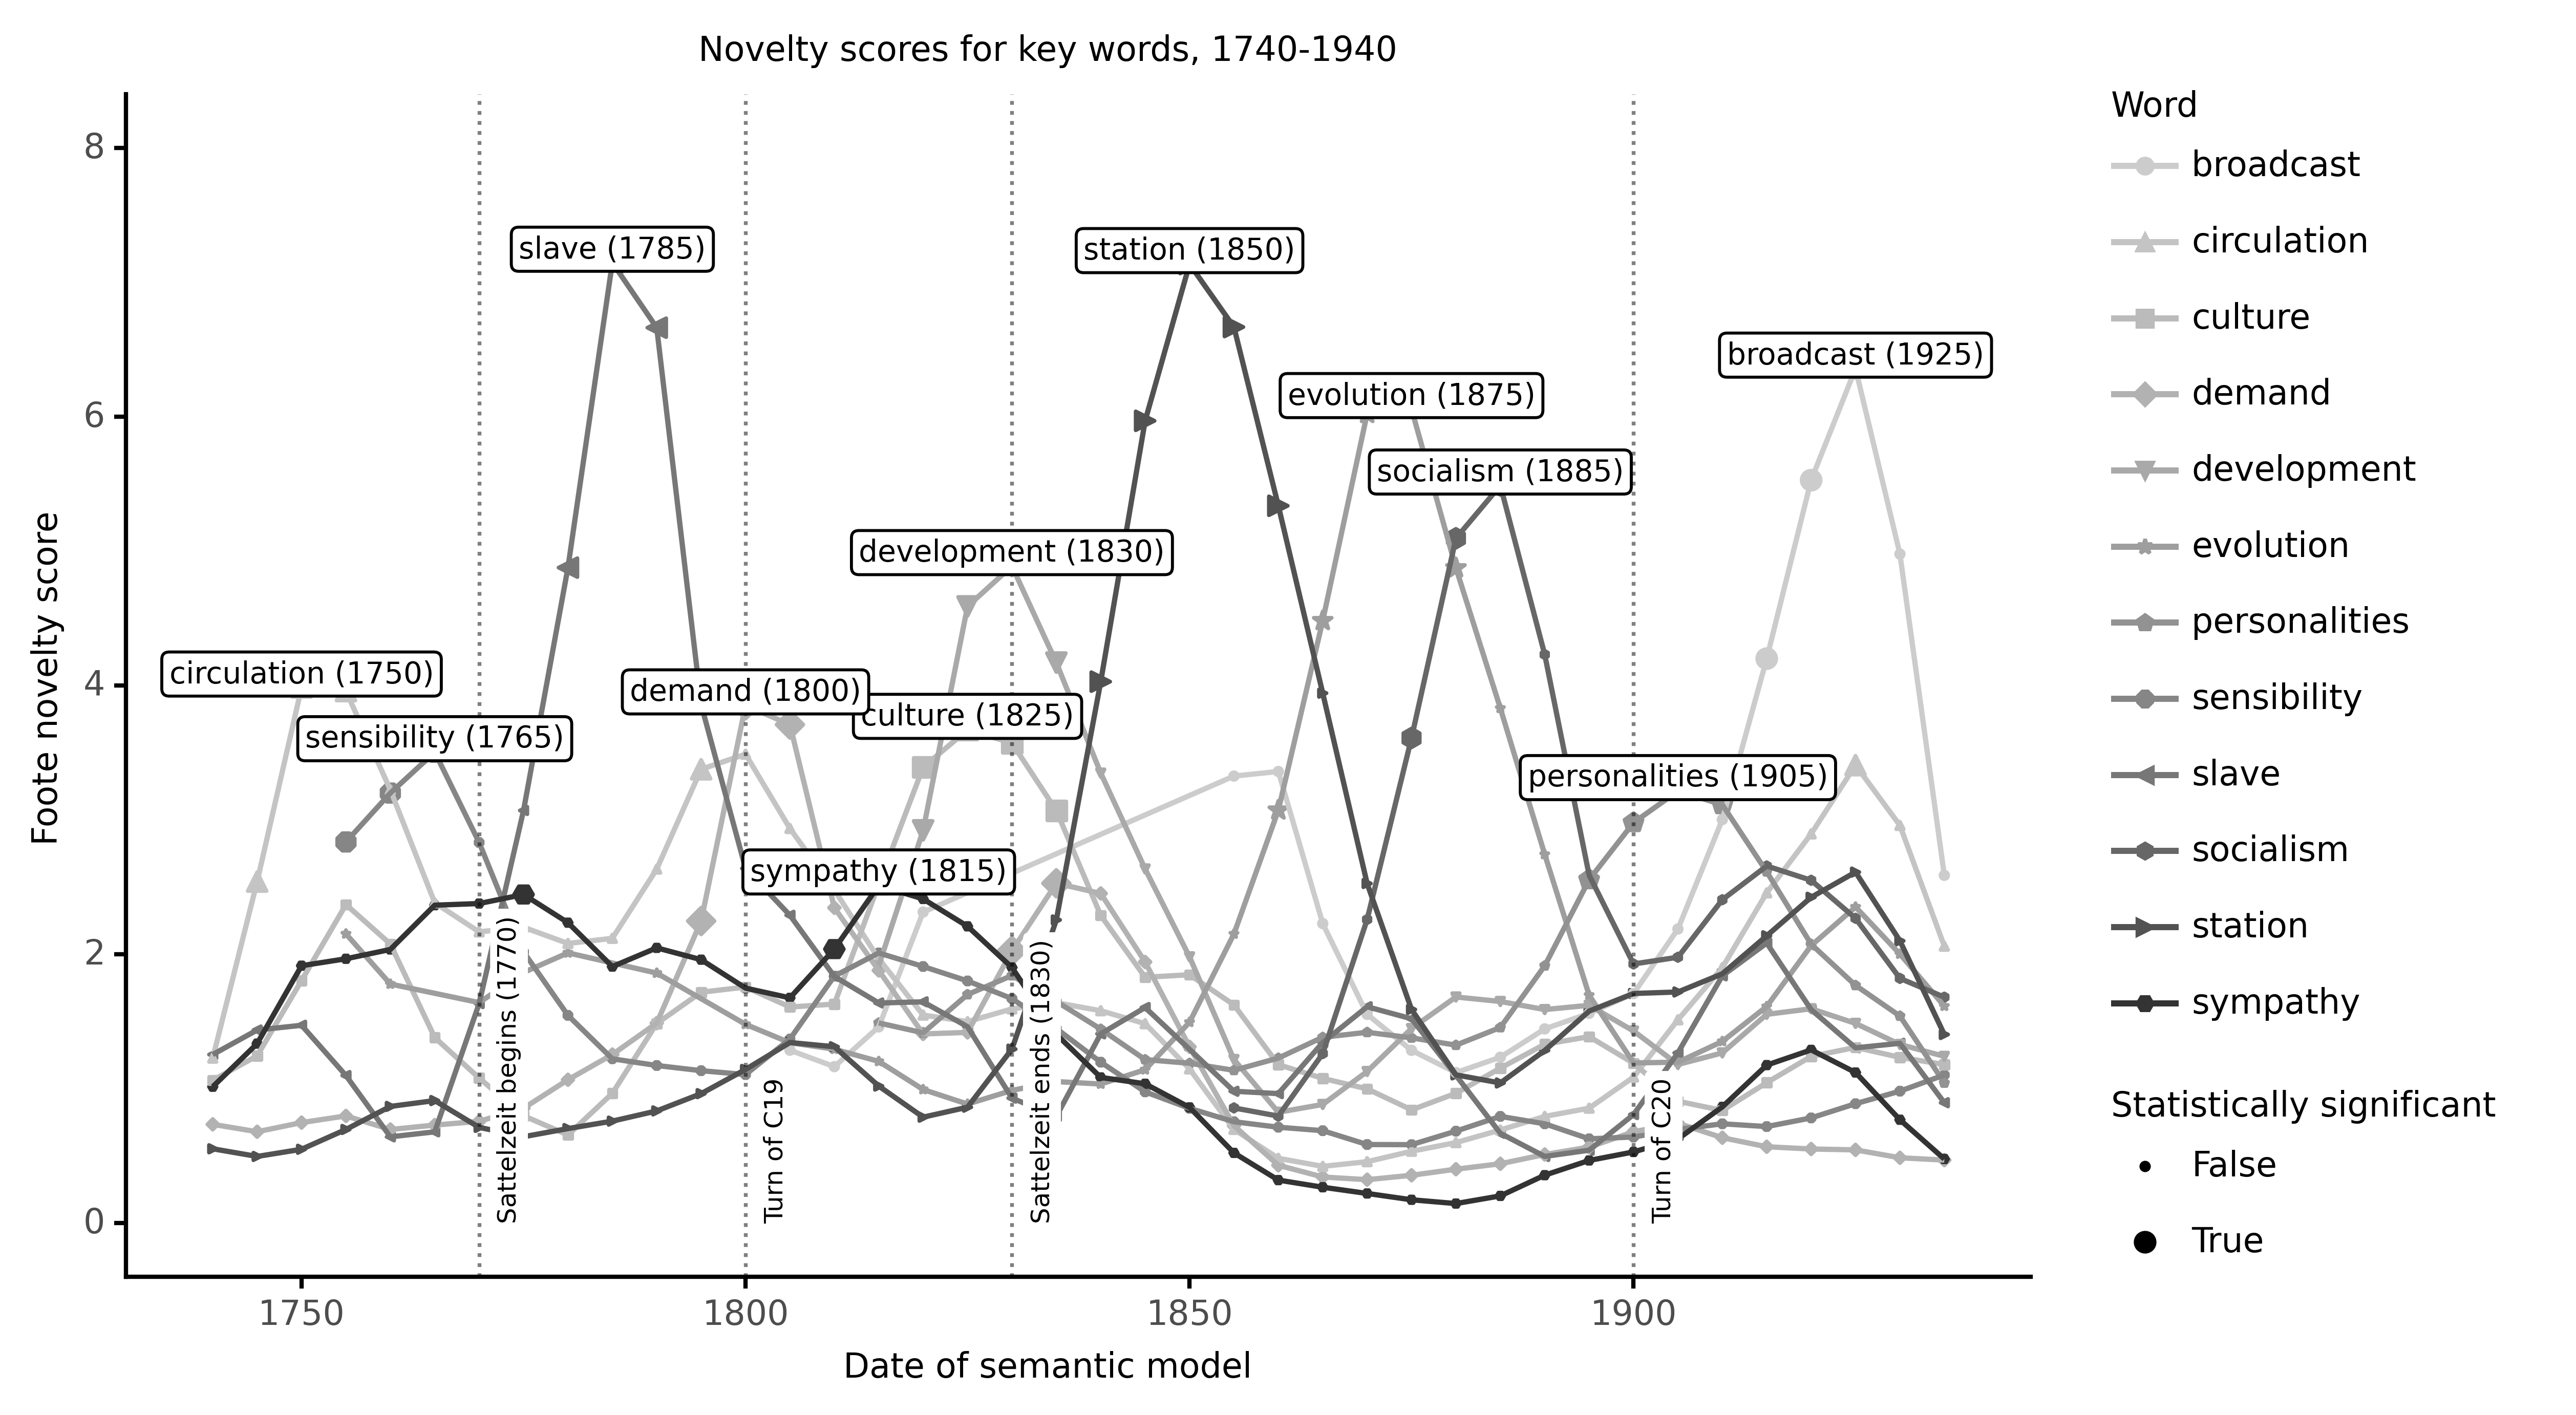

<ggplot: (8762931732438)>

In [147]:
plot_nov_word('''
circulation
slave
demand
broadcast
station
sympathy
culture
evolution
example
sensibility
socialism
development
personalities
''',min_foote_size=4,max_foote_size=6)

[Koselleck] (11:59:56) Number of unique neighbors: 16 (+2092.8s)


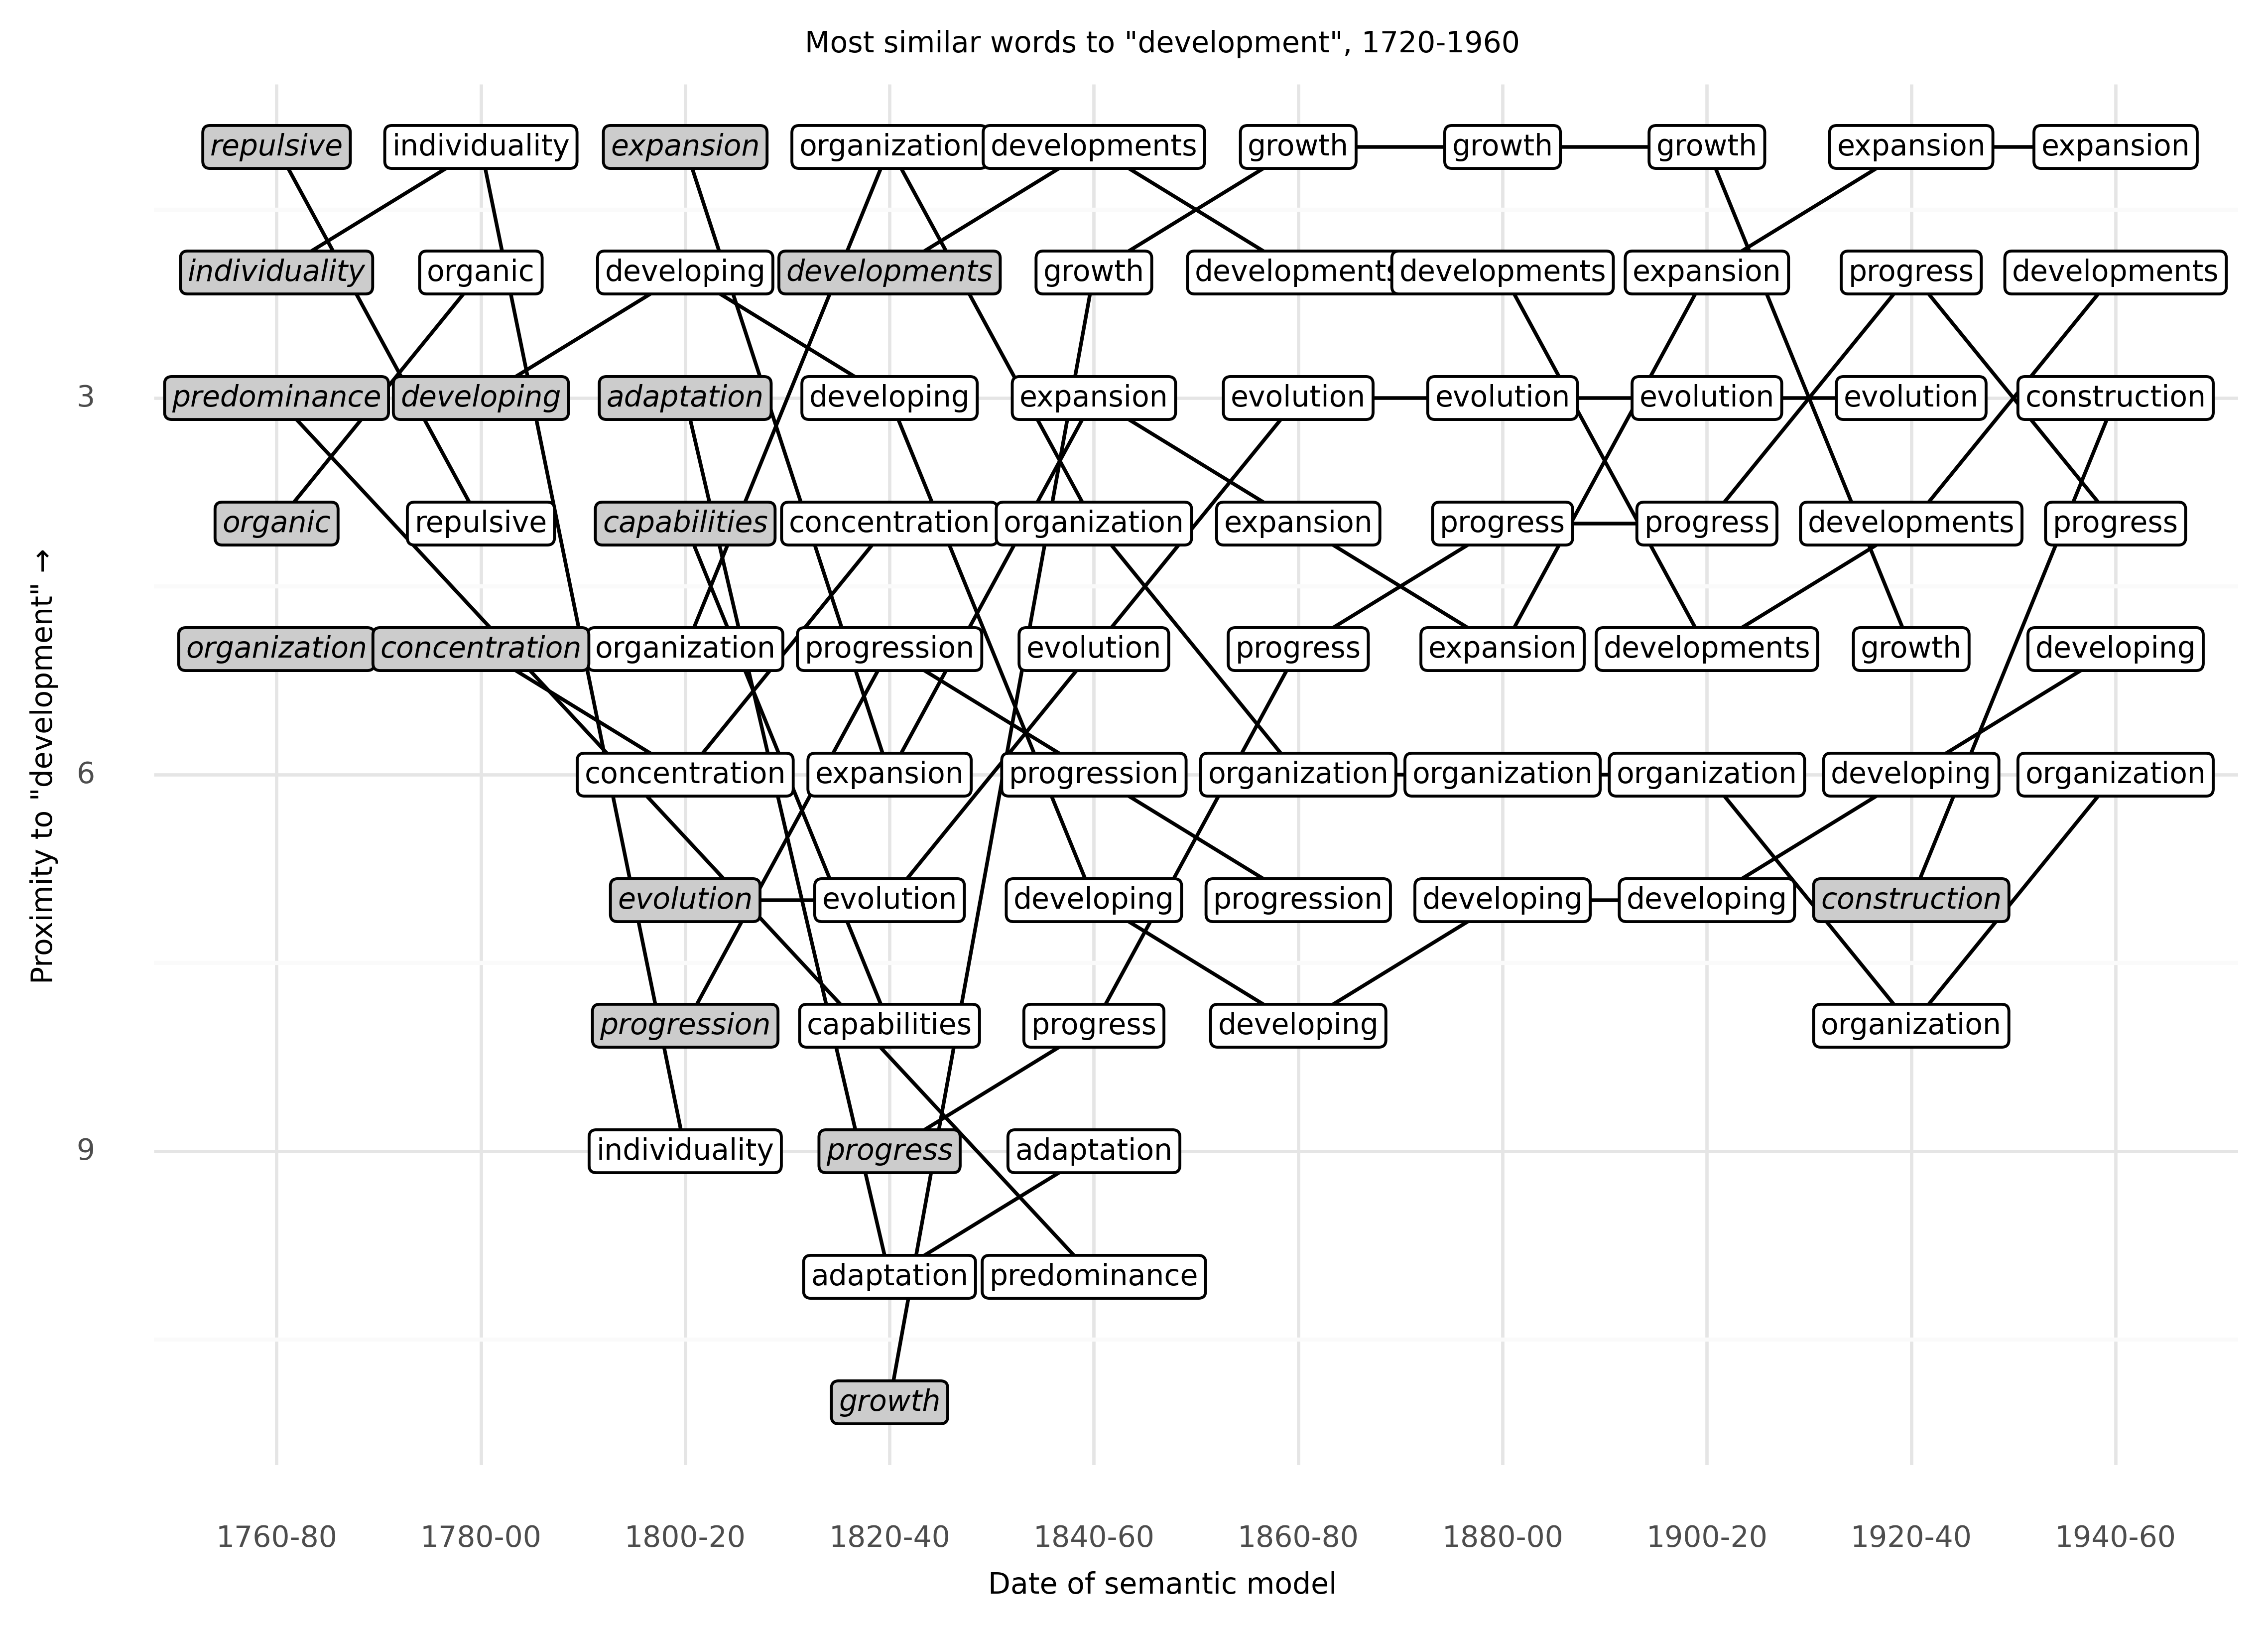

<ggplot: (8762883040762)>

In [148]:
plot_nbrs('development')

## Examine

In [65]:
#plot_nov_word('value,virtue,station',min_foote_size=6)
novwordsnow='culture liberal liberty station'# circulation'
res=interact_manual_plot(plot_nov_word, word_or_words=novwordsnow,min_foote_size=5,max_foote_size=5,
                        min_period=1750,max_period=1930)

interactive(children=(Text(value='culture liberal liberty station', description='word_or_words'), Text(value='…

In [66]:
# p9.geom_rect??

In [49]:
# p9.geom_vline??

In [28]:
# def plot_nov_signif(figdf=None,y='num_peaks',save=False,showdata=False,vnum='v3',
#                     key='_figdf_nov_signif_',force=False,
#                     rolling_n=2,rolling_min_periods=2,returndata_all=False,force_data=False,
#                     by_foote_size=False
#                    ):
#     p9.options.dpi=300
#     nudge_x=2
#     ymin=0
#     labsize=6
    
#     if figdf is None:
#         if not force:
#             with get_db('nov') as db:
#                 if key in db: figdf=db[key]
    
#     if figdf is None:
#         cats=[
#             ('all','I. All words'),
#             ('lax','II. Signif. (p<.05)'),
#             ('strict','III. Signif. (p<.05 in 2 consecutive periods)'),
# #             ('lax_nofs','Signif. (p<.05; no suspicious OCR words)'),
#             ('strict_nofs','IV. Signif. (p<.05 in 2 consecutive periods; excl. words with "f" or "s")'),
# #             ('strict_nofs_first','Signif. (words) (p<.001 in 3 consecutive periods; no suspicious OCR words)')
#         ]
#         dfnov_all=get_signif_novelty_scores(
#             min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
#             p_peak=1,consecutive_peaks=False,min_periods=1,
#             ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,force=force_data,
#             only_peak_scores=True
#         )
# #         display(dfnov_all)
#         dfnov_lax=get_signif_novelty_scores(
#             min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
#             p_peak=.05,consecutive_peaks=False,min_periods=1,
#             ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,force=force_data,
#             only_peak_scores=True
#         )
# #         display(dfnov_lax)
#         dfnov_strict=get_signif_novelty_scores(
#             min_foote_size=MINFOOTENOW,max_foote_size=MAXFOOTENOW,
#             p_peak=.05,consecutive_peaks=True,min_periods=2,
#             ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT,ybin=YBIN_DISTMAT,force=force_data,
#             only_peak_scores=True
#         )
#         dfnov_strict_nofs=dfnov_strict[dfnov_strict.word.apply(is_safe_fs)]
# #         dfnov_lax_nofs=dfnov_lax[dfnov_lax.word.apply(is_safe_fs)]

# #         dfnov_srict_nofs_first=dfnov_strict_nofs.sort_values('foote_novelty',ascending=False).drop_duplicates('word')
#         dfl=[
#             dfnov_all,
#             dfnov_lax,
#             dfnov_strict,
# #             dfnov_lax_nofs,
#             dfnov_strict_nofs,
# #             dfnov_srict_nofs_first
#         ]
#         if returndata_all:
#             return pd.concat(
#                 dfx.assign(dtype2=cat[1],dtype3=cat[1])
#                 for cat,dfx in zip(cats,dfl)
#             )
        
#         figdf=pd.concat(
#             make_figdf(
#                 dfx,rolling_n=rolling_n,rolling_min_periods=rolling_min_periods
#             ).assign(dtype2=ystr, dtype3=xstr)
#             for ((xstr,ystr),dfx) in zip(cats,dfl)
#         )
#         figdf['dtype2']=pd.Categorical(figdf.dtype2, categories=[yy for xx,yy in cats])
#         figdf['dtype3']=pd.Categorical(figdf.dtype3, categories=[xx for xx,yy in cats])
#         # figdf.sort_values('period')
#         figdf['foote_size']=figdf.foote_size.apply(lambda x: f'{int(x)*5*2} year window')
# #         print(figdf.period.describe())
#         figdf=figdf.query('1750<=period<1930')
# #         print(figdf.period.describe())
#         with get_db('nov','w') as db: db[key]=figdf
    
#     if not by_foote_size:
#         figdf=figdf.groupby(['period','pos','dtype2']).agg(
#             {'num_peaks':'sum','foote_novelty':'mean'}
#         ).reset_index()
#         figdf['group']=[f'{x}_{y}' for x,y in zip(figdf.pos,figdf.dtype2)]
#     else:
#         figdf['group']=figdf['foote_size']
    
#     if showdata: display(figdf)
#     fig=start_fig(
#         figdf,
#         x='period',
#         y=y,
#     #     linetype='foote_size',
#         shape='pos' if not by_foote_size else 'foote_size',
#         color='pos' if not by_foote_size else 'foote_size',
#         group='group',#pos' if not by_foote_size else 'foote_size',
#         theme='classic',
#         size='foote_novelty',
#         figure_size=(8,8)
#     ) + p9.geom_point() + p9.geom_line(size=.5)
    
# #     fig+=p9.geom_smooth(method='loess',alpha=.2,span=.4,size=.5)
#     fig+=p9.geom_vline(xintercept=1770,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_vline(xintercept=1830,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_label(label='Sattelzeit begins (1770)',x=1770+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')
#     fig+=p9.geom_label(label='Sattelzeit ends (1830)',x=1830+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')
#     fig+=p9.geom_label(label='Turn of C19',x=1900+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')
#     fig+=p9.geom_label(label='Turn of C20',x=2000+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0),ha='left')

#     fig+=p9.facet_wrap('dtype2',ncol=1,scales='free_y')#,nrow=1)#,ncol=1
# #     fig+=p9.facet_grid('dtype2~pos',scales='free_y')#,nrow=1)#,ncol=1
# #     fig+=p9.facet_grid('dtype2~foote_size',scales='free_y')#,nrow=1)#,ncol=1
#     fig+=p9.scale_color_gray(start=.8,end=.2)
#     fig+=p9.scale_size_continuous([.5,2])
#     fig+=p9.labs(
#         title='Number of words which "pivot", or reach their peak novelty score, in a given period',
#         y='Number of words pivoting in this period',
#         x='Pivot period for word (its peak novelty period)'
#     )
#     if save: fig.save(f'../figures/fig.nov_summary.{y}.{vnum}.png')
#     return fig